# Advanced RAG - Handling Missing Content
* Notebook by Adam Lang
* Date: 10/9/2024

# Overview
* We will go over one of the issues that is commonly seen with RAG systems which is "missing content".
* If a user sends a query to your system and the information is "just not there", the LLM will either give the WRONG answer or it can/will hallucinate an answer.
* These are some techniques to handle those issues.

# Dependencies Details
* We need to install tools from unstructured.io which is an open source tool.
* This will allow us to parse PDFs, tables, images and other multi-modal RAG data.
* This will allowus to separate the data as well as perform better chunking.
* These tools are as follows:
1. unstructured.io
2. tesseract-ocr
3. poppler-utils

## Install dependencies

In [1]:
!pip install langchain
!pip install langchain-openai
!pip install langchain-community

In [2]:
## need to install unstructured.io --> can take up to 5 mins
!pip install "unstructured[all-docs]"

In [3]:
## install OCR dependencies for unstructured.io
!sudo apt-get install tesseract-ocr
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


## Download PDF Data
* We will load a PDF document as an example.
* It is an arxiv paper.

In [4]:
!wget -O 'layoutparser_paper.pdf' 'http://arxiv.org/pdf/2103.15348'

--2024-10-09 15:18:29--  http://arxiv.org/pdf/2103.15348
Resolving arxiv.org (arxiv.org)... 151.101.131.42, 151.101.67.42, 151.101.3.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.131.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4686220 (4.5M) [application/pdf]
Saving to: ‘layoutparser_paper.pdf’

layoutparser_paper. 100%[===================>]   4.47M  --.-KB/s    in 0.04s   

2024-10-09 15:18:29 (114 MB/s) - ‘layoutparser_paper.pdf’ saved [4686220/4686220]



# 1. UnstructuredPDFLoader - Getting cleaner data
* This is one of the simpler strategies to simply make sure that we extract, clean and parse the data into better chunks for our RAG pipeline.
  * This alone will not solve the "missing content" problem, but it can help quite a bit to know WHAT IS IN THE DATA!
* `Unstructured.io` supports a common interface for working with unstructred or semi-structured file formats such as Markdown or PDF.
* Langchain has an `UnstructuredPDFLoader` which integrates with Unstructured to parse PDF documents into LangChain `Document` objects.

In [5]:
!pip install --upgrade --force-reinstall nltk

import nltk
import os

# set environment variable
os.environ['NLTK_DATA'] = '/usr/local/share/nltk_data'

nltk.download('punkt')
nltk.download('punkt_tab')

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached regex-2024.9.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.9.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (782 kB)
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.5
    Uninstalling tqdm-4.66.5:
      Successfully uninstalled tqdm-4.66.5
  Attempting uninstall: regex
    Found existing installation: regex 2024.9.11
    Uninstalling regex-2024.9.11:
      Successfully uninstalled regex-2024.9.11
  Attempting uninstall: joblib
    Found

[nltk_data] Downloading package punkt to /usr/local/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
## imports for unstructuredPDFLoader
from langchain_community.document_loaders import UnstructuredPDFLoader

Load PDF with:
* Complex parsing
* Table detection
* Chunking by sections

In [7]:
## setup the UnstructuredPDFLoader --> takes a few minutes!
loader = UnstructuredPDFLoader('/content/layoutparser_paper.pdf',
                               strategy='hi_res', # high-resolution extraction
                               extract_images_in_pdf=True, # extract images
                               infer_table_structure=True, # extract tables
                               chunking_strategy='by_title', # section-based chunking --> instead of character
                               max_characters=4000, # max size of chunks
                               new_after_n_chars=3800, # preferred size of chunks
                               combine_text_under_n_chars=2000, # smaller chunks < 2000 chars will be considered
                               mode='elements')


In [8]:
## load the data
data = loader.load()

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
## len of data
len(data)

18

In [10]:
[doc.metadata['category'] for doc in data]

['CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'Table',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'Table',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement']

In [11]:
# lets view a doc
data[0]

Document(metadata={'source': '/content/layoutparser_paper.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2023-01-23T09:15:33', 'page_number': 1, 'orig_elements': 'eJzNWW1v3DYS/iu8/ZQclqpIkXrxl4uTAJe07l2QuNeiaWBQ5GiXiVYSRMnOJuh/vyGlddbetHACrOFPXr4MZ+aZZ2ZI+e3nBdSwgWa4sGZxQhaiFGXBeUqrOFFUiIzTvABNs4wXWa7SPMn0YkkWGxiUUYNCmc8L3ba9sY0awIVxrbbtOFyswa7WA85wHscoM09fWTOscZZlYbZrbTN4ubdvhYzEksiCR9m7JZmHKY8j4YcsjqPicDxtx4mF27oBNt6LV/Yj1G86pWHxJy5UtoZh20FYevXzItjSrEa1Cga/XUCzWrwLs2642LTGVhYCHDzmCY0Z5cl5XJwweZIkXrpDyYtm3JTQe0e8jgE+elcXzK/vlP3SaARl1fb2E5hzvwO33oZcaqNECZImcQJUgFA0z2JOtRAgecZkmsqjQS5ZFHsM0yj2mE5D3DUN8/wrw2nzgwEcJb4d87yqRM55RjNdZVSkwGkpEklzVZa6iAuDpD8yza95PA9FHvF9mt8eh+0PB/VvhlwnpUnyOEU9OqZC5SVVVRlTViqlKgmxEfGxId9hOg+zmfU7iG+Pw/YHA3n8zZCzKjNJahg1hdZYzAVDgpsMITciLbKkFIU4NuSpjOQXyBkmWVTsYXwwMQn8LegGBtCDbZsLjbC6i65vS9wWR1LESXrfiUAaMpIfCSOcvCP/I89IRBzR5C2OL0lOBEmIxNUI/8Zh18l+HF+AMnjoV4JXpCVnpRQUf2C+pNiTFTeKykJlSayNLDk/cvCY4EXE9qMn0yi/Eb2DiSDxYHLmch/rczvU8FWoheZ

In [12]:
## print data
print(data[0].page_content)

1

2021

2

0

2 n u J 1 2 ] V C . s c [ 2 v 8 4 3 5 1 . 3 0 1 2 :

v

arXiv

i

X

r

a

LayoutParser: A Uniﬁed Toolkit for Deep Learning Based Document Image Analysis

Zejiang Shen! (4), Ruochen Zhang”, Melissa Dell?, Benjamin Charles Germain Lee*, Jacob Carlson’, and Weining Li®

1 Allen Institute for AI shannons@allenai.org 2 Brown University ruochen zhang@brown.edu 3 Harvard University {melissadell,jacob carlson}@fas.harvard.edu 4 University of Washington bcgl@cs.washington.edu 5 University of Waterloo w422li@uwaterloo.ca

Abstract. Recent advances in document image analysis (DIA) have been primarily driven by the application of neural networks. Ideally, research outcomes could be easily deployed in production and extended for further investigation. However, various factors like loosely organized codebases and sophisticated model conﬁgurations complicate the easy reuse of im- portant innovations by a wide audience. Though there have been on-going eﬀorts to improve reusability and 

Lets see another chunk

In [13]:
## chunk 5
data[5].page_content

'Dataset Base Model1 Large Model Notes PubLayNet [38] F / M M Layouts of modern scientiﬁc documents PRImA [3] M - Layouts of scanned modern magazines and scientiﬁc reports Newspaper [17] F - Layouts of scanned US newspapers from the 20th century TableBank [18] F F Table region on modern scientiﬁc and business document HJDataset [31] F / M - Layouts of history Japanese documents'

In [14]:
from IPython.display import HTML

HTML(data[5].metadata['text_as_html'])

Dataset,| Base Model'|,| Notes
PubLayNet B8]|,F/M,Layouts of modern scientific documents
PRImA,M,Layouts of scanned modern magazines and scientific report
Newspaper,F,Layouts of scanned US newspapers from the 20th century
TableBank,F,Table region on modern scientific and business document
HJDataset,F/M,Layouts of history Japanese documents


You can store these in tables --> create vectors --> and store in a vector database.
* A strategy for this wouldbe to store the metadata with the question and answers.

### Below we see images extracted from PDF

In [15]:
! ls -1 ./figures

figure-10-4.jpg
figure-11-5.jpg
figure-13-6.jpg
figure-4-1.jpg
figure-6-2.jpg
figure-9-3.jpg


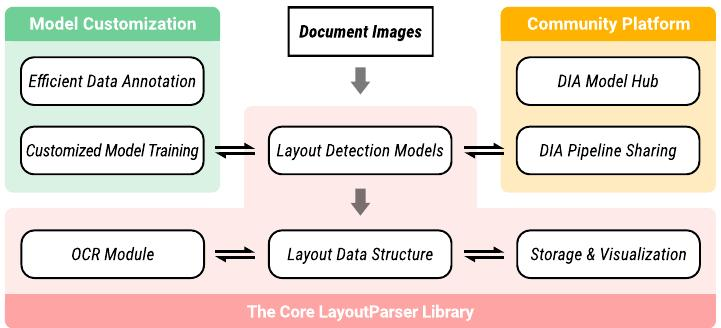

In [16]:
## we can print the images extracted from the PDF!
from IPython.display import Image

Image('./figures/figure-4-1.jpg')

Summary
* What can we do with the images?
* Pass them to a computer vision or multimodal LLM --> ask it to generate captions or extract the text
* Then we can vectorize and embed the text and pass it to the vector database as part of our RAG pipeline.
* We also saw above that we were able to chunk and extract the data in a more efficient and clean manner.

# 2. Better Prompting for More Consistent Results
* To do this we need to use an LLM, we can use Open AI.
* The concept is using better prompts to prevent hallucinations!

In [17]:
## enter your OPEN AI API KEY
from getpass import getpass


OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


In [18]:
## set up environment variables
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

## Load LLM connection to GPT

In [19]:
from langchain_openai import ChatOpenAI

## init chatgpt
chatgpt = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0)

## Problematic RAG Prompt Example

In [32]:
from langchain_core.prompts import ChatPromptTemplate

## prompt -- Question given at runtime
prompt = """You are an assistant for question-answering tasks.
            Give an answer to the following question with the context provided

            Question:
            {question}

            Context:
            {context}

            Answer:
        """

## prompt template
prompt_template = ChatPromptTemplate.from_template(prompt)

In [33]:
context = """
The 2023 Stanley Cup champion was the Vegas Golden Knights.

The 2024 Stanley Cup champion was the Florida Panthers.
"""

question = "Who is the 2020 euro league champ?"

## QA-RAG chain
qa_rag_chain = (
    prompt_template
      |
    chatgpt
)

In [34]:
## invoke LLM response via qa-rag chain
response = qa_rag_chain.invoke({'context': context, 'question': question})
print(response.content)

The question is asking about the 2020 Euro League champion, not the Stanley Cup champions.


Summary:
* Aha, we can see that the model did not answer the question because we gave it specific examples for the Stanley Cup or ice hockey thinking that was what our domain of questions would be.
* The LLM was steered towards answering ice hockey or stanley cup questions instead of just giving us the answer to who won the euro league in 2020 which was Italy.
* Now, you could imagine that if you had a chatbot in production that used domain specific data and instead of telling us the information is not available or defering the answer, the LLM hallucinates or gives a wrong answer entirely.
* So how can we fix that?

## Better RAG Prompt
* The difference here is we are giving the LLM constraints in our prompt telling it to only answer the question if it can verify the response with actual retrieved contextual data.

In [35]:
from langchain_core.prompts import ChatPromptTemplate

## better prompt
prompt = """You are an assistant for question-answering tasks.
         Use the following pieces of retrieved context to answer the question.
         If no context is present or if you don't know the answer, just say you don't know.
         Do not make up the answer unless it is there in the provided context.

         Question:
         {question}

         Context:
         {context}

         Answer:
        """

## init prompt template
prompt_template = ChatPromptTemplate.from_template(prompt)

In [37]:
## send to qa-rag chain
qa_rag_chain = (
    prompt_template
      |
    chatgpt
)

In [38]:
## invoke response from better prompt qa-rag chain
response = qa_rag_chain.invoke({'context': context, 'question': question})
print(response.content)

I don't know.


Summary:
* Aha! This is much better, the LLM response was directed to simply say it did not know the answer.

# 3. Advanced RAG Technique - Agentic RAG with Tools

## What reallly is an Agent?
* LLM + Prompts + Tools
  * Prompts instruct the LLM to understand which tools to call to solve specific problems.
  * However, tool calls need to be carried out separately.
* This is an advanced technique to solve the problem of missing content or information.
* We create an agent (function) and give a tool to the agent to search a knowledge base (e.g. google, wikipedia, or anything you want such as an API or other data source), so it can find the answer to missing content.

## Do you need a system like LangGraph to do this?
* If you are building a large complex AI system then maybe, but for most systems you don't need something like LangGraph.
  * It will add to the overall cost and complexity.
* Agents and tools can be custom built and can be easily implemented as we will see below.

## Tavily Search API key

In [39]:
TAVILY_API_KEY = getpass('Enter Tavily Search API key: ')

Enter Tavily Search API key: ··········


In [40]:
## setup tavily environment
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## Setting up the "Search Tool"
* We need a search tool to give to the agent.
* We will use the Tavily Search API.
* You can use any tool you want or need.
  * Databases, online repos, wikipedia, etc.

In [41]:
from langchain_community.tools.tavily_search import TavilySearchResults # search tool
from langchain_core.tools import tool
import rich #enrich the text outputs

# build search tool
@tool
def search_tool(query: str) -> list:
  """Tavily Search API tool to search web"""
  tavily_tool = TavilySearchResults(max_results=3, #get top 3 results
                                    search_depth='advanced', #detailed search
                                    max_tokens=10000)
  # get results
  results = tavily_tool.invoke(query)
  return [doc['content'] for doc in results]

In [42]:
## recall our question to llm
question

'Who is the 2020 euro league champ?'

In [44]:
## call the tool
search_tool(question)

<ipython-input-44-2ec77483f391>:2: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  search_tool(question)


["Italy are the champions of Europe. On Saturday in the Euro 2020 final, the Italians defeated England in a penalty shootout to become the undisputed kings of the continent. The win is Italy's ...",
 'The 2020 UEFA European Football Championship, commonly referred to as UEFA Euro 2020 or simply Euro 2020, was the 16th UEFA European Championship, ... was announced that the 55 members at the time would be drawn into ten groups after the completion of the UEFA Nations League (five groups of five teams and five groups of six teams, with the four ...',
 'It was a heartbreaking loss for England at Wembley Stadium. Italy are the champions of Europe after a tense Euro 2020 final victory over England that was decided on penalty kicks. Italy beat ...']

Summary:
* We can see it retrieved top 3 search results via the internet.'
* However, we need to bind this to the LLM to get a more interpretable answer to the query.

## Bind Tools to LLM
* First we need to bind the tools to the LLM.

In [45]:
# create list of tool or tools
tools = [search_tool]

## init llm we are using --> chatgpt
chatgpt = ChatOpenAI(model_name = 'gpt-4o-mini', temperature=0)

## bind tool to llm
chatgpt_with_tools = chatgpt.bind_tools(tools)

## Better RAG Prompt with Tool Calling
* Now we can use the BETTER RAG prompt with the tool --> we prompt the LLM to call the tool.
* This time if the LLM does not know the answer based on the data at hand, it can use the tool we created.

In [47]:
from langchain_core.prompts import ChatPromptTemplate

## better RAG prompt
prompt = """You are an assistant for question-answering tasks.
         Use the following pieces of retrieved context to answer the question.
         If no context is present or if you don't know the answer,
         check and see if you can use the tools available to get the answer.

         Question:
         {question}

         Context:
         {context}

         Answer:
        """

## init prompt template
prompt_template = ChatPromptTemplate.from_template(prompt)


## init qa-rag chain
qa_rag_chain = (
    prompt_template
      |
    chatgpt_with_tools
)

In [48]:
# give context again to LLM
context = """
The 2023 Stanley Cup champion was the Vegas Golden Knights.

The 2024 Stanley Cup champion was the Florida Panthers.
"""

question = "Who is the 2020 euro league champ?"

# invoke qa-rag chain and LLM response
qa_rag_chain.invoke({'context': context, 'question': question})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qT1dgvcg4SitG7XSUnOVe2ec', 'function': {'arguments': '{"query":"2020 EuroLeague champion"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 146, 'total_tokens': 164, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e79891bf-33fa-4a2c-8c53-af8d3adb79db-0', tool_calls=[{'name': 'search_tool', 'args': {'query': '2020 EuroLeague champion'}, 'id': 'call_qT1dgvcg4SitG7XSUnOVe2ec', 'type': 'tool_call'}], usage_metadata={'input_tokens': 146, 'output_tokens': 18, 'total_tokens': 164, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

We were able to get the LLM to use the tool to answer the question.

In [50]:
## ask another similar question
question = "Who is the 2024 Stanley Cup Champion?"

# invoke chain
qa_rag_chain.invoke({'context': context, 'question': question})

AIMessage(content='The 2024 Stanley Cup champion is the Florida Panthers.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 146, 'total_tokens': 159, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'stop', 'logprobs': None}, id='run-21d2e358-8485-4457-b721-11dccfdd7b52-0', usage_metadata={'input_tokens': 146, 'output_tokens': 13, 'total_tokens': 159, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

Summary:
* The answer was already available to the LLM in the prompt context we gave it so the answer was immediate without having to call the tool.

## Simple Agentic RAG with Tool Calls
* This is the code above just as a function.

In [52]:
## agentic rag
def agentic_rag(question, context):
  """Agentic RAG function"""
  # create tool call map
  tool_call_map = {'search_tool': search_tool}
  # initially just call RAG pipeline
  response = qa_rag_chain.invoke({'context': context, 'question': question})

  # if response content is present then we have answer immediate
  if response.content:
    print("Answer is in retrieved context")
    answer = response.content

  # if no response content present then call search tool
  elif response.tool_calls:
    print('Answer not in context, trying to use available tools')
    ## call tool
    tool_call = response.tool_calls[0]
    selected_tool = tool_call_map[tool_call['name'].lower()]
    print(f"Calling tool: {tool_call['name']}")
    # tool output
    tool_output = selected_tool.invoke(tool_call['args'])
    context = '\n\n'.join(tool_output)
    # get response from qa_rag_chain
    response = qa_rag_chain.invoke({'context': context, 'question': question})
    # generate answer
    answer = response.content

  # no answer found from web search also
  else:
    answer = 'No answer found'

  print(answer)

In [55]:
# give context again to LLM
context = """
The 2023 Stanley Cup champion was the Vegas Golden Knights.

The 2024 Stanley Cup champion was the Florida Panthers.
"""

question = "Who is the 2024 Stanley Cup champ?"

# agentic rag function and LLM response
agentic_rag(question, context)

Answer is in retrieved context
The 2024 Stanley Cup champion is the Florida Panthers.


In [56]:
## now we ask question LLM doesnt know
question = "Who is the euro 2024 champion"

agentic_rag(question, context)

Answer not in context, trying to use available tools
Calling tool: search_tool
Spain is the Euro 2024 champion, having defeated England 2-1 in the final. This victory marks Spain's fourth European Championship title.
